In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

from lifelines.datasets import load_waltons
df = load_waltons() 

In [2]:
df['group'].unique()

array(['miR-137', 'control'], dtype=object)

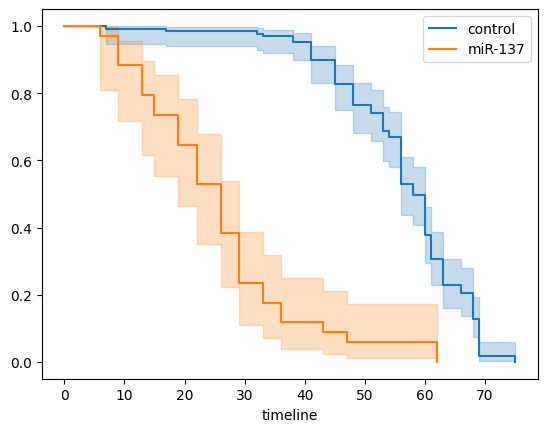

In [3]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
group_dfs = []
for name, grouped_df in df.groupby('group'):
    group_dfs.append(grouped_df)
    kmf.fit(grouped_df['T'], grouped_df['E'], label=name)
    kmf.plot_survival_function()

In [4]:
from lifelines.statistics import logrank_test, multivariate_logrank_test

t0 = 20
res = logrank_test(
    group_dfs[0]["T"], 
    group_dfs[1]["T"],
    group_dfs[0]["E"],
    group_dfs[1]["E"],
    t_0=t0
)
res.test_statistic

41.8595583505775

In [5]:
Nij = [[], []]
Oij = [[], []]
for i in range(2):
    gdf = group_dfs[i]
    for j in range(t0+1):
        Nij[i].append(gdf.loc[gdf['T'] >= j].shape[0])
        # Oij[i].append(gdf.loc[(gdf['T'] < j + 1e-5) & gdf['E']].shape[0])
        Oij[i].append(gdf.loc[(np.abs(gdf['T'] - j) < 1e-5) & gdf['E']].shape[0])
Nij = np.array(Nij)
Oij = np.array(Oij)
Nj = Nij.sum(axis=0)
Oj = Oij.sum(axis=0)
Eij = Nij * (Oj / Nj)
Vij = Eij * ((Nj - Oj) / Nj) * ((Nj - Nij) / (Nj - 1))
test_stat = np.sum(Oij - Eij, axis=1) ** 2 / np.sum(Vij, axis=1)
test_stat[0]

41.85955835057754

In [6]:
import scipy.stats
rvs = scipy.stats.expon.rvs(size=(10, 2))
control_rvs = rvs[:,0] 
hazard_ratio = 0.7
treatment_rvs = rvs[:,1] / hazard_ratio

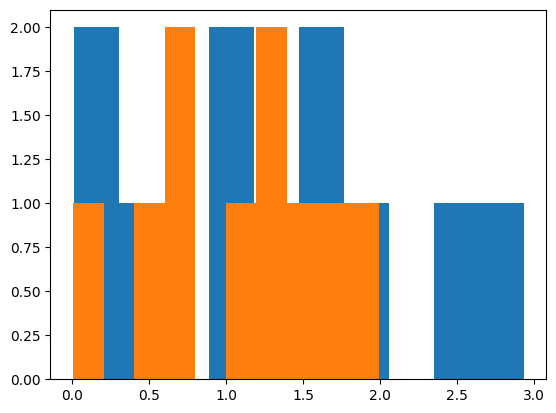

In [7]:
plt.hist(treatment_rvs)
plt.hist(control_rvs)
plt.show()

In [8]:
censoring_time = 4
all_rvs = np.concatenate([control_rvs, treatment_rvs])
group = np.concatenate([np.zeros(control_rvs.shape[0]), np.ones(treatment_rvs.shape[0])]).astype(bool)

In [9]:
ordering = np.argsort(all_rvs)
ordered_group = group[ordering]
ordered = all_rvs[ordering]
Nij = [[], []]
Oij = [[], []]
events_so_far = [0, 0]
max_idx = np.argmin(ordered <= censoring_time)
for j in range(max_idx):
    for i in range(2):
        event_now = ordered_group[j] == (i == 1)
        Nij[i].append(rvs.shape[0] - events_so_far[i])
        Oij[i].append(event_now)
        events_so_far[i] += event_now
Nij = np.array(Nij)
Oij = np.array(Oij)
Nj = Nij.sum(axis=0)
Oj = Oij.sum(axis=0)
Eij = Nij * (Oj / Nj)
Vij = Eij * ((Nj - Oj) / Nj) * ((Nj - Nij) / (Nj - 1))
test_stat = np.sum(Oij - Eij, axis=1) ** 2 / np.sum(Vij, axis=1)
test_stat[0]

nan

In [10]:
multivariate_logrank_test(ordered, ordered_group, t0=4).test_statistic

1.1831316754143306

In [13]:
all_rvs

array([0.00591388, 0.47949334, 1.3139232 , 1.29835678, 1.67547287,
       1.4300453 , 1.16746867, 1.99207251, 0.72515423, 0.63107217,
       0.59359626, 2.93579483, 0.01441062, 1.74647466, 1.61885635,
       0.90851458, 2.57288191, 1.9274417 , 0.0922669 , 0.94859954])

In [18]:
ordering = jnp.argsort(all_rvs)
ordered = all_rvs[ordering]
ordered_group = group[ordering]
max_idx = jnp.argmin(ordered <= censoring_time)
if max_idx == 0 and jnp.all(ordered <= censoring_time):
    max_idx = ordered.shape[0]
event_now = jnp.stack((~ordered_group, ordered_group), axis=0) * (
    jnp.arange(ordered.shape[0]) < max_idx
)
events_so_far = jnp.concatenate(
    (jnp.zeros((2, 1)), event_now.cumsum(axis=1)[:, :-1]), axis=1
)
Nij = rvs.shape[0] - events_so_far
Oij = event_now
Nj = Nij.sum(axis=0)
Oj = Oij.sum(axis=0)
Eij = Nij * (Oj / Nj)
Vij = Eij * ((Nj - Oj) / Nj) * ((Nj - Nij) / (Nj - 1))
denom = jnp.sum(jnp.where(~jnp.isnan(Vij[0]), Vij[0], 0), axis=0)
test_stat = jnp.sum(Oij[0] - Eij[0], axis=0) ** 2 / denom

In [19]:
test_stat

DeviceArray(1.1831315, dtype=float32)

In [23]:
@jax.vmap
@jax.jit
def logrank_test(all_rvs, group, censoring_time):
    ordering = jnp.argsort(all_rvs)
    ordered = all_rvs[ordering]
    ordered_group = group[ordering]
    include = ordered <= censoring_time
    event_now = jnp.stack((~ordered_group, ordered_group), axis=0) * include
    events_so_far = jnp.concatenate(
        (jnp.zeros((2, 1)), event_now.cumsum(axis=1)[:, :-1]), axis=1
    )
    Nij = rvs.shape[0] - events_so_far
    Oij = event_now
    Nj = Nij.sum(axis=0)
    Oj = Oij.sum(axis=0)
    Eij = Nij * (Oj / Nj)
    Vij = Eij * ((Nj - Oj) / Nj) * ((Nj - Nij) / (Nj - 1))
    denom = jnp.sum(jnp.where(~jnp.isnan(Vij[0]), Vij[0], 0), axis=0)
    return jnp.sum(Oij[0] - Eij[0], axis=0) ** 2 / denom

logrank_test(jnp.array([all_rvs]), jnp.array([group]), jnp.array([censoring_time]))


DeviceArray([1.1831315], dtype=float32)

In [26]:
rvs = scipy.stats.expon.rvs(size=(100000, 10, 2))
control_rvs = rvs[:,:,0] 
hazard_rate = 0.7
treatment_rvs = rvs[:,:,1] / hazard_rate
all_rvs = np.concatenate([control_rvs, treatment_rvs], axis=1)
group = np.concatenate([np.zeros(control_rvs.shape), np.ones(treatment_rvs.shape)], axis=1).astype(bool)
censoring_time = np.full(control_rvs.shape[0], 4)

In [29]:
%%time
np.any(np.isnan(logrank_test(all_rvs, group, censoring_time)))

CPU times: user 159 ms, sys: 10.7 ms, total: 170 ms
Wall time: 143 ms


False

In [ ]:
# The model here is survival analysis:
# - recruit n patients at t=0
# - observe them until censoring_time.
class LogRank:
    def __init__(self, seed, max_K, *, n, censoring_time):
        self.censoring_time = censoring_time
        self.n = n
        self.family = 